In [1]:
import numpy as np
import pandas as pd
import h5py
import matplotlib.pyplot as plt
import scipy.stats as st
import joblib

from scipy.stats import t
from sklearn import datasets
from random import choices
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV, PredefinedSplit
from sklearn.metrics import confusion_matrix, f1_score, matthews_corrcoef, mean_squared_error, ConfusionMatrixDisplay, accuracy_score

In [2]:
def main():
    
    prot_embeddings_in = 'protein_embeddings_only_enzymes.h5'

    # read per-protein embeddings into a dictionary with key: Uniprot id, value: 1024-d embedding
    counter = 0
    prot_embeddings = dict()
    with h5py.File(prot_embeddings_in, 'r') as f:
        for key, embedding in f.items():
            original_id = embedding.attrs['original_id']
            prot_embeddings[original_id] = np.array(embedding)
    return prot_embeddings

enzyme_embeddings = pd.DataFrame.from_dict(main())

In [3]:
annotations = pd.read_csv('Data_set/ec_annotations_single.tab', sep='\t')
annotations['EC number'] = annotations['EC number'].str[:1]
training = pd.read_table('Data_set/train_set.fasta', sep='\n', skiprows=lambda x: (x != 0) and not x % 2 == 0)
validation = pd.read_table('Data_set/val_set.fasta', sep='\n', skiprows=lambda x: (x != 0) and not x % 2 == 0)
test = pd.read_table('Data_set/test_set.fasta', sep='\n', skiprows=lambda x: (x != 0) and not x % 2 == 0)
head = training.columns
training.loc[-1] = head[0]
training.reset_index(drop=True, inplace=True)
training.rename(columns={head[0]: 'Entry'}, inplace=True)
training['Entry'] = training['Entry'].str[1:]
head = validation.columns
validation.loc[-1] = head[0]
validation.reset_index(drop=True, inplace=True)
validation.rename(columns={head[0]: 'Entry'}, inplace=True)
validation['Entry'] = validation['Entry'].str[1:]
head = test.columns
test.loc[-1] = head[0]
test.reset_index(drop=True, inplace=True)
test.rename(columns={head[0]: 'Entry'}, inplace=True)
test['Entry'] = test['Entry'].str[1:]

In [4]:
training_embeddings = (((enzyme_embeddings[enzyme_embeddings.columns.intersection(training['Entry'].tolist())]).T).reset_index(level=0)).rename(columns={'index': 'Entry'})
validation_embeddings = (((enzyme_embeddings[enzyme_embeddings.columns.intersection(validation['Entry'].tolist())]).T).reset_index(level=0)).rename(columns={'index': 'Entry'})
test_embeddings = (((enzyme_embeddings[enzyme_embeddings.columns.intersection(test['Entry'].tolist())]).T).reset_index(level=0)).rename(columns={'index': 'Entry'})

In [18]:
X_train = pd.merge(training_embeddings, annotations)
y_train = X_train['EC number']
X_train.drop(columns=['Entry', 'EC number'], inplace = True)
y_train = y_train.to_numpy(dtype=int)
X_val = pd.merge(validation_embeddings, annotations)
y_val = X_val['EC number']
X_val.drop(columns=['Entry', 'EC number'], inplace = True)
y_val = y_val.to_numpy(dtype=int)
X_test = pd.merge(test_embeddings, annotations)
y_test = X_test['EC number']
X_test.drop(columns=['Entry', 'EC number'], inplace = True)
y_test = y_test.to_numpy(dtype=int)
# X_train = pd.concat([X_train, X_val]).reset_index(drop=True)
# y_train = np.concatenate((y_train, y_val))

In [6]:
# predefined_val = np.empty((17790))
# predefined_val.fill(-1)

# for i in range(17663, 17790):
#     predefined_val[i] = 0
# ps = PredefinedSplit(test_fold = predefined_val)

In [7]:
# classifier = MLPClassifier(hidden_layer_sizes=(400, 72,), solver='adam', activation='relu', 
#                            early_stopping=False, warm_start=True)

# params = {'random_state': [14, 27, 39],
#          'learning_rate_init': [0.01, 0.005, 0.001],
#          'max_iter': [50, 100, 150, 200, 300]}

# grid = GridSearchCV(estimator=classifier, cv=ps, param_grid=params, 
#                    return_train_score=True, n_jobs = 2, verbose = 10, scoring='f1_weighted')

# grid.fit(X_train, y_train)
# pd.set_option('display.max_rows', None)

In [8]:
# params_layers = []
# for x in range(256, 513, 32):
#     for y in range(64, x+1, 64):
#         params_layers.append((x,y))
# len(params_layers)

In [9]:
# cv_results = pd.DataFrame(grid.cv_results_)
# print(grid.best_params_) 
# cv_results

In [10]:
# classifier = MLPClassifier(hidden_layer_sizes=x, activation='relu', solver='adam', 
#                                early_stopping=False, learning_rate_init=0.001, max_iter=120, warm_start=True)
# classifier.fit(X_train, y_train)

In [11]:
classifier = joblib.load('final-per-protein')

In [12]:
y_pred = classifier.predict(X_val)
pred_score = classifier.score(X_val, y_val)
val = pd.merge(validation_embeddings, annotations)
bootstrapping_acc = []
bootstrapping_mcc = []
bootstrapping_f1 = []
for i in range(1000):
    choice = pd.DataFrame(choices(val.to_numpy(), k=127))
    y_choice = choice[1025].to_numpy(dtype=int)
    X_choice = choice.drop(columns=[0, 1025])
    acc = classifier.score(X_choice, y_choice)
    mcc = matthews_corrcoef(y_choice, classifier.predict(X_choice))
    f1 =  f1_score(y_choice, classifier.predict(X_choice), average = 'weighted')
    bootstrapping_acc.append(acc)
    bootstrapping_mcc.append(mcc)
    bootstrapping_f1.append(f1)

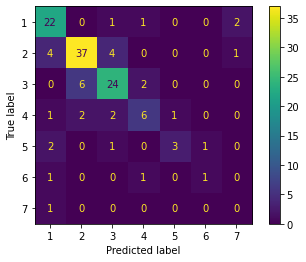

Acc: 0.73228
F1: 0.7326016158175296
MCC: 0.6434934542821036
SE for Accuracy: 0.038539815498193
SE for MCC: 0.050045488881934316
SE for F1: 0.0401840374470412
CI for Accuracy: 0.07562818611994337
CI for MCC: 0.09820621865208318
CI for F1: 0.07885470710772077


In [13]:
SE_acc = np.std(bootstrapping_acc)
SE_mcc = np.std(bootstrapping_mcc)
SE_f1 = np.std(bootstrapping_f1)
cm = confusion_matrix(y_val, y_pred)
f1 = f1_score(y_val, y_pred, average = 'weighted')
mcc = matthews_corrcoef(y_val, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classifier.classes_)
disp.plot()
plt.show()
print('Acc: {}'.format(round(pred_score, 5)))
print('F1:', f1)
print('MCC:', mcc)
print('SE for Accuracy:', SE_acc)
print('SE for MCC:', SE_mcc)
print('SE for F1:', SE_f1)
print('CI for Accuracy:', np.std(bootstrapping_acc) * t.ppf((1 + 0.95) / 2, len(bootstrapping_acc)))
print('CI for MCC:', np.std(bootstrapping_mcc) * t.ppf((1 + 0.95) / 2, len(bootstrapping_mcc)))
print('CI for F1:', np.std(bootstrapping_f1) * t.ppf((1 + 0.95) / 2, len(bootstrapping_f1)))

In [14]:
y_pred = classifier.predict(X_test)
pred_score = classifier.score(X_test, y_test)
test = pd.merge(test_embeddings, annotations)
bootstrapping_acc = []
bootstrapping_mcc = []
bootstrapping_f1 = []
for i in range(1000):
    choice = pd.DataFrame(choices(test.to_numpy(), k=127))
    y_choice = choice[1025].to_numpy(dtype=int)
    X_choice = choice.drop(columns=[0, 1025])
    acc = classifier.score(X_choice, y_choice)
    mcc = matthews_corrcoef(y_choice, classifier.predict(X_choice))
    f1 =  f1_score(y_choice, classifier.predict(X_choice), average = 'weighted')
    bootstrapping_acc.append(acc)
    bootstrapping_mcc.append(mcc)
    bootstrapping_f1.append(f1)

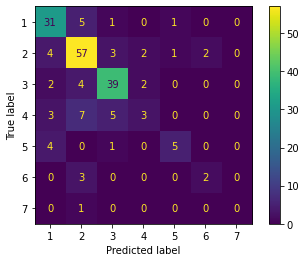

Acc: 0.72872
F1: 0.708619653240633
MCC: 0.632107198749175
SE for Accuracy: 0.03978309268255708
SE for MCC: 0.05205487996116448
SE for F1: 0.04387084702690485
CI for Accuracy: 0.07806791752712083
CI for MCC: 0.10214932529552048
CI for F1: 0.08608947762985239


In [15]:
SE_acc = np.std(bootstrapping_acc)
SE_mcc = np.std(bootstrapping_mcc)
SE_f1 = np.std(bootstrapping_f1)
cm = confusion_matrix(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average = 'weighted')
mcc = matthews_corrcoef(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classifier.classes_)
disp.plot()
plt.show()
print('Acc: {}'.format(round(pred_score, 5)))
print('F1:', f1)
print('MCC:', mcc)
print('SE for Accuracy:', SE_acc)
print('SE for MCC:', SE_mcc)
print('SE for F1:', SE_f1)
print('CI for Accuracy:', np.std(bootstrapping_acc) * t.ppf((1 + 0.95) / 2, len(bootstrapping_acc)))
print('CI for MCC:', np.std(bootstrapping_mcc) * t.ppf((1 + 0.95) / 2, len(bootstrapping_mcc)))
print('CI for F1:', np.std(bootstrapping_f1) * t.ppf((1 + 0.95) / 2, len(bootstrapping_f1)))

In [16]:
# import seaborn as sns

# plot = sns.heatmap(cm, annot=True, center=20.0, cbar=False)
# plot.set_xticklabels([1,2,3,4,5,6,7])
# plot.set_yticklabels([1,2,3,4,5,6,7])
# plt.xlabel('Predicted label', fontsize=16)
# plt.ylabel('True label', fontsize=16)
# plot.set_title('Confusion Matrix', fontsize=20)
# fig=plot.get_figure()
# fig.savefig('confusion_matrix1.png')